In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import requests
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Fetching the Data from Alpha Vantage API

In [3]:
def fetch_stock_data(api_key, symbol, outputsize='full'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df = df.apply(pd.to_numeric)
    df.index = pd.to_datetime(df.index)
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return df

api_key = '837HCGC79E7O4F8V'
symbol = 'AAPL'
df = fetch_stock_data(api_key, symbol)
print(df.head())

              Open     High       Low   Close    Volume
2024-05-30  190.76  192.180  190.6300  191.29  49947941
2024-05-29  189.61  192.247  189.5100  190.29  53068016
2024-05-28  191.51  193.000  189.1000  189.99  52280051
2024-05-24  188.82  190.580  188.0404  189.98  36326975
2024-05-23  190.98  191.000  186.6250  186.88  51005924


#### Saving the dataset as csv file

In [4]:
df.to_csv('stock_data.csv')

### Visualising the Average Prices over time 

In [5]:
def calculate_mid_prices(df):
    df['Mid_price'] = (df['High'] + df['Low']) / 2.0
    return df

def visualize_data(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Mid_price'], label='Mid Price')
    plt.title('Stock Mid Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Mid Price (USD)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

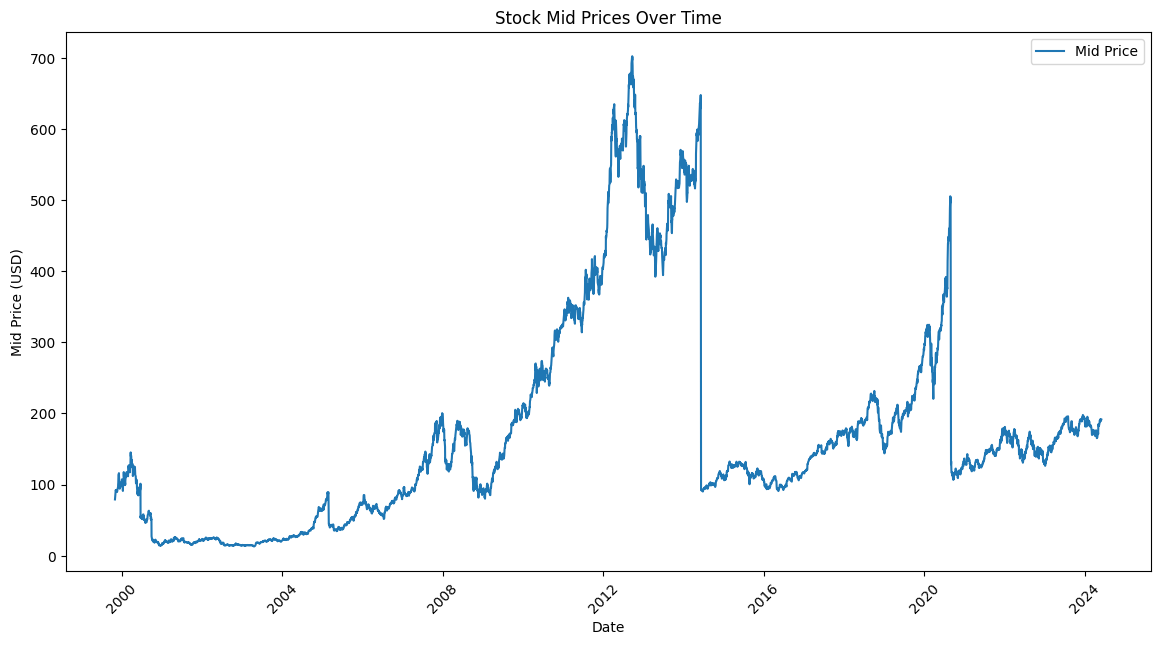

In [6]:
df = calculate_mid_prices(df)
visualize_data(df)

### Data Pre-processing

#### Normalization and Train-Test split of Data

In [7]:
# Only use the 'close' column for prediction
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [8]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (4886, 60, 1)
Testing data shape: (1176, 60, 1)


### Model Building

In [9]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(look_back, 1)
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10)))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#### Keras Tuner setup

In [10]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='stock_prediction'
)

### Hyperparameter Tuning

After finding best parameters, model is declared and trained.

In [11]:
# Perform the search for the best hyperparameters
tuner.search(X_train, Y_train, epochs=10, validation_split=0.2, batch_size=32)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

Trial 10 Complete [00h 00m 32s]
val_loss: 5.000451346859336e-05

Best val_loss So Far: 3.864418431476224e-05
Total elapsed time: 00h 05m 42s
Epoch 1/50
123/123 [==============================] - 5s 15ms/step - loss: 0.0061 - val_loss: 6.7811e-04
Epoch 2/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 2.7995e-04
Epoch 3/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 1.2007e-04
Epoch 4/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 6.4796e-05
Epoch 5/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 6.4080e-05
Epoch 6/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 1.4030e-04
Epoch 7/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 2.2559e-04
Epoch 8/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 7.8323e-05
Epoch 9/50
123/123 [======

#### Best parameters for the model

In [12]:
# Print the best hyperparameters
print(f"The optimal number of units in the LSTM layer is {best_hps.get('units')}")
print(f"The optimal dropout rate is {best_hps.get('dropout_rate')}")
print(f"The optimal number of units in the dense layer is {best_hps.get('dense_units')}")

The optimal number of units in the LSTM layer is 128
The optimal dropout rate is 0.4
The optimal number of units in the dense layer is 20


### Prediction 

In [16]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the true values for comparison
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
test_rmse = math.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

37/37 [==============================] - 0s 4ms/step
Train RMSE: 11.303060655310228
Test RMSE: 7.95122483919838


## Plot of the Results

### Plot between actual and predicted prices (For training and testing data)

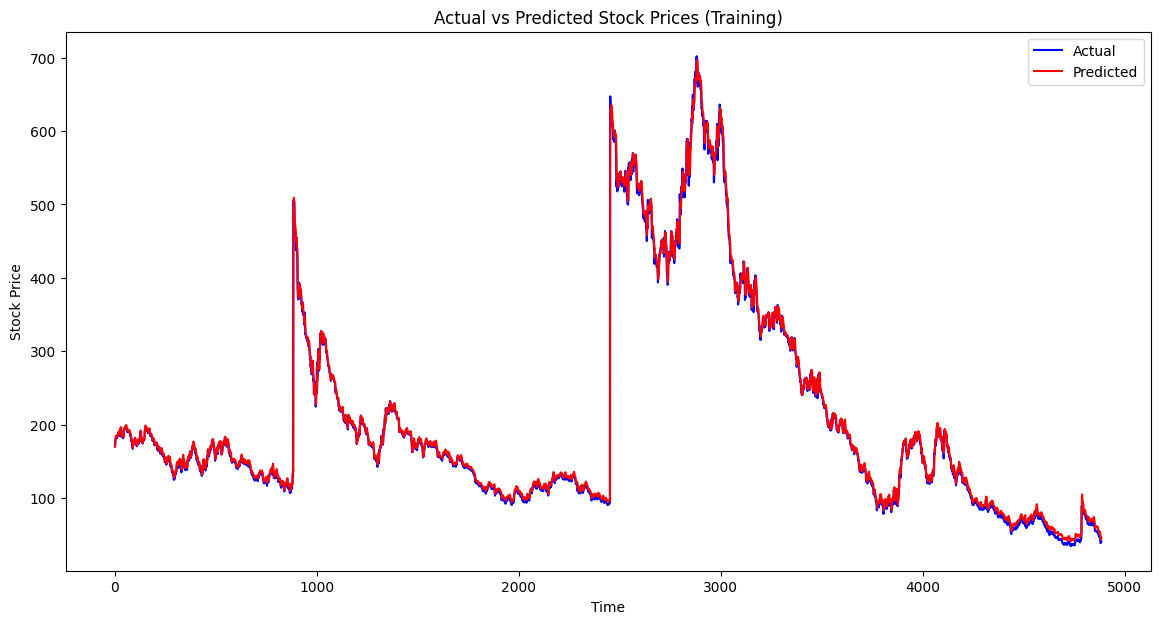

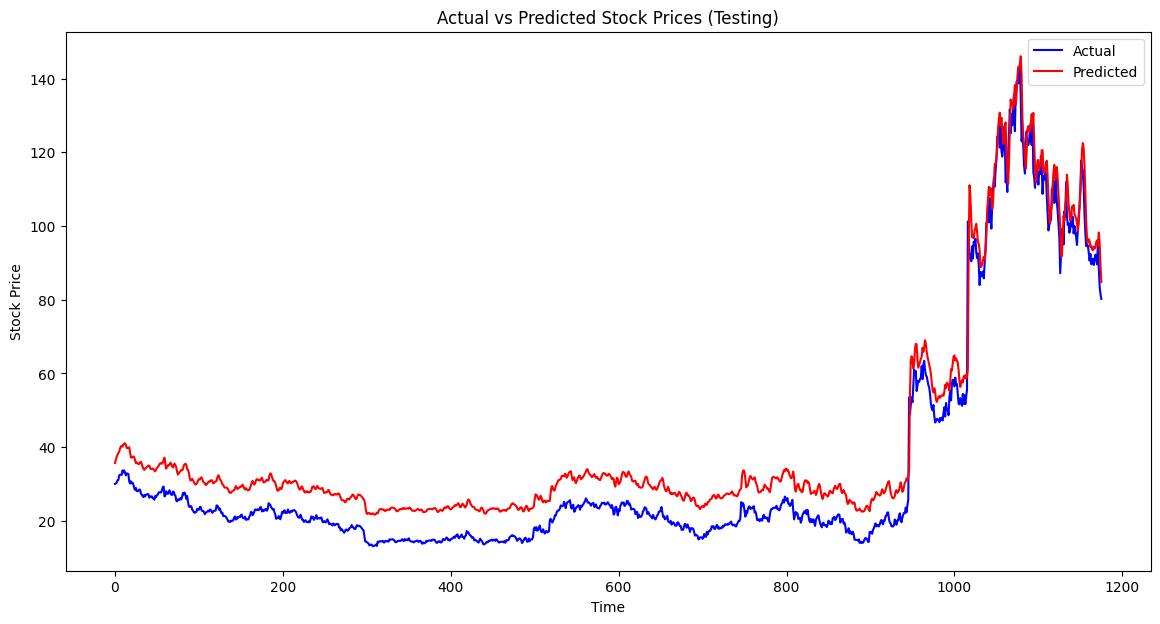

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(Y_train_inv[0], label='Actual', color='blue')
plt.plot(train_predict, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices (Training)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(Y_test_inv[0], label='Actual', color='blue')
plt.plot(test_predict, label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices (Testing)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()